In [1]:
import sys
import os

from copy import deepcopy
import h5py

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

myhost = os.uname()[1]
sys.path.insert(0, '/home/elott1/code/')
data_dir = "/home/elott1/data/packaged/"
work_dir = '/home/elott1/code/NTdatasets/hartley/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")

print(f'Running on Computer: [{myhost}]')
print(f'Data directory: {data_dir}')
print(f'Working directory: {work_dir}')

%load_ext autoreload
%autoreload 2

# NDN tools
import NDNT.utils as utils          # some other utilities\n",
from NDNT.utils import imagesc      # because I'm lazy\n",
from NDNT.utils import ss           # because I'm real lazy\n",
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

Running on Computer: [PFC]
Data directory: /home/elott1/data/packaged/
Working directory: /home/elott1/code/NTdatasets/hartley/
Invoking __init__.py for NDNT.utils


In [2]:
from NTdatasets.hartley.hartley import HartleyDataset

# Load data files
fn0 = 'Jocamo_220628_full_HC_ETCC_nofix_v08'
f = h5py.File(os.path.join(data_dir, fn0+'.mat'), 'r')
expts = [fn0]

# Initialize dataset
data = HartleyDataset(
    filenames=expts,
    datadir=data_dir,
    num_lags=10,
    time_embed=2,
    include_MUs=False,
    preload=True,
    drift_interval=None,
    device=device0,
    eye_config=3,
    maxT=8000
)

# Calculate stas
Reff = data.robs * data.dfs
nspks = torch.sum(Reff, axis=0)
stas = ((data.meta.T @ Reff).squeeze() / nspks).reshape([data.one_hots.shape[3],data.num_lags,-1]).numpy()

Loading data into memory...
Stim: using laminar probe stimulus
  Adding fixation point
  Time embedding...
  Done
  Time embedding...
	Done
T-range: 0 8000
Extending final block at  7920 8000


In [3]:
# Init optimizer parameters
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    batch_size=2000,
    max_iter=200)

# Init GLM layer
glm_layer = NDNLayer.layer_dict(
    input_dims=[1,1,data.one_hots.shape[3],data.num_lags],
    num_filters=data.NC,
    bias=True,
    NLtype='softplus',
    initialize_center=False)

XTreg = 1.0
L1reg = 0.0001

glm_layer['reg_vals'] = {'d2xt': XTreg, 'l1': L1reg}
stim_net = FFnetwork.ffnet_dict(xstim_n='meta', layer_list=[glm_layer])

In [3]:
# Init optimizer parameters
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    batch_size=1000,
    max_iter=200)

XTreg = 1.0
L1reg = 0.0001

glm_layer0 = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=True,
    NLtype='softplus',
    initialize_center=True
)

glm_layer0['reg_vals'] = {'d2xt': XTreg, 'l1': L1reg}
stim_net0 = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[glm_layer0])

torch.cuda.empty_cache()
tr_ind = data.train_inds
v_ind = data.val_inds

glm0 = NDN.NDN(  
    ffnet_list = [stim_net0],
    loss_type='poisson')

glm0.fit(data, train_inds=tr_ind[:3000], force_dict_training=True, **lbfgs_pars, verbose=2)

Model: M140_N

GPU Available: True, GPU Used: True
Iteration: 0 | Loss: 0.7456561923027039
Iteration: 1 | Loss: 0.7456231713294983
Iteration: 2 | Loss: 0.42872732877731323
Iteration: 3 | Loss: 0.3545377552509308
Iteration: 4 | Loss: 0.2948484420776367
Iteration: 5 | Loss: 0.24680915474891663
Iteration: 6 | Loss: 0.21640510857105255
Iteration: 7 | Loss: 0.19606873393058777
Iteration: 8 | Loss: 0.18148380517959595
Iteration: 9 | Loss: 0.1719980239868164
Iteration: 10 | Loss: 0.1647655963897705


RuntimeError: CUDA out of memory. Tried to allocate 58.00 MiB (GPU 0; 5.93 GiB total capacity; 4.32 GiB already allocated; 66.12 MiB free; 4.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [4]:
torch.cuda.empty_cache()
tr_ind = data.train_inds
v_ind = data.val_inds

glm = NDN.NDN(  
    ffnet_list = [stim_net],
    loss_type='poisson')

glm.fit(data, train_inds=tr_ind, force_dict_training=True, **lbfgs_pars, verbose=2)

Model: M201_N

GPU Available: True, GPU Used: True
Iteration: 0 | Loss: 0.8018142580986023
Iteration: 1 | Loss: 0.8013708591461182
Iteration: 2 | Loss: 0.4644966125488281
Iteration: 3 | Loss: 0.4440378248691559
Iteration: 4 | Loss: 0.42862752079963684
Iteration: 5 | Loss: 0.42239439487457275
Iteration: 6 | Loss: 0.41531628370285034
Iteration: 7 | Loss: 0.4117642939090729
Iteration: 8 | Loss: 0.4083315134048462
Iteration: 9 | Loss: 0.40606576204299927
Iteration: 10 | Loss: 0.4049028158187866
Iteration: 11 | Loss: 0.4026748538017273
Iteration: 12 | Loss: 0.4033741056919098
Iteration: 13 | Loss: 0.4017086327075958
Iteration: 14 | Loss: 0.4014676809310913
Iteration: 15 | Loss: 0.4009508788585663
Iteration: 16 | Loss: 0.4005766212940216
Iteration: 17 | Loss: 0.40031710267066956
Iteration: 18 | Loss: 0.4000202715396881
Iteration: 19 | Loss: 0.39984938502311707
Iteration: 20 | Loss: 0.3996070325374603
Iteration: 21 | Loss: 0.39926761388778687
Iteration: 22 | Loss: 0.3989669680595398
Iteration

In [5]:
LLi = glm.eval_models(data, val_inds=v_ind, null_adjusted=True)
print(LLi)
print(np.mean(LLi))

Eval models: 100%|██████████| 10/10 [00:00<00:00, 10.16it/s]


[0.07013535 0.07405782 0.22873592 0.13183093 0.08974123 0.14823413
 0.11032045 0.05899978 0.08038497 0.03204322 0.04933357 0.01751935
 0.04020381 0.07564592 0.04870987 0.09648895 0.04450989 0.11755848
 0.09052372 0.18575668 0.0697794  0.0913372  0.48304868 0.0339036
 0.03417706 0.06349421 0.12287331 0.10126543 0.1772877  0.02565479
 0.03931189 0.03172922 0.0224514  0.02065611 0.00428963 0.03481412
 0.03323674 0.04428697 0.03408289 0.02807426 0.04085469 0.03768468
 0.02313972 0.04329276 0.02609491 0.04378104 0.02897644 0.04435849
 0.03208685 0.02255154 0.03944063 0.0305388  0.02703691 0.02219391
 0.01245785 0.0505271  0.03179312 0.03125858 0.06088638 0.02613711
 0.03069162 0.02585602 0.01472664 0.02854848 0.02950096 0.02507806
 0.02918077 0.01436698 0.02988553 0.03465867 0.01614285 0.02375817
 0.03514957 0.0408926  0.03899097 0.02807593 0.02668405 0.03733373
 0.02418613 0.02147985 0.0450294  0.03730416 0.03928781 0.0397234
 0.0437336  0.03631759 0.02511597 0.04131651 0.04691839 0.019448

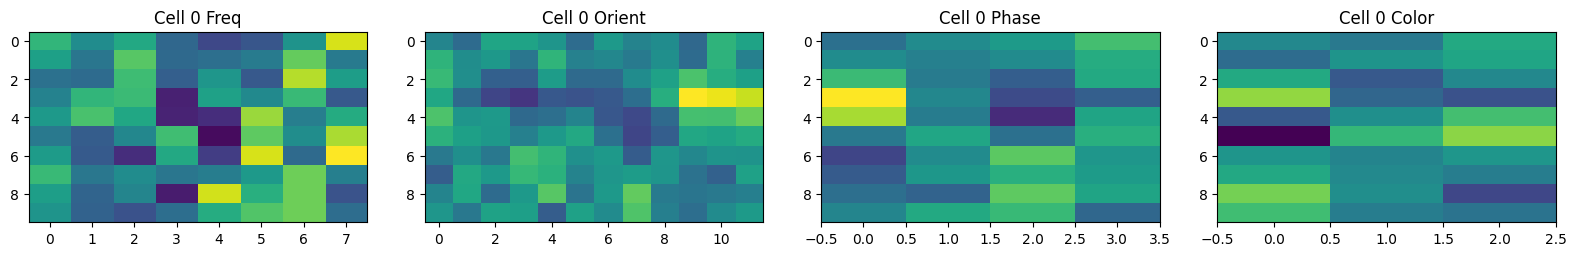

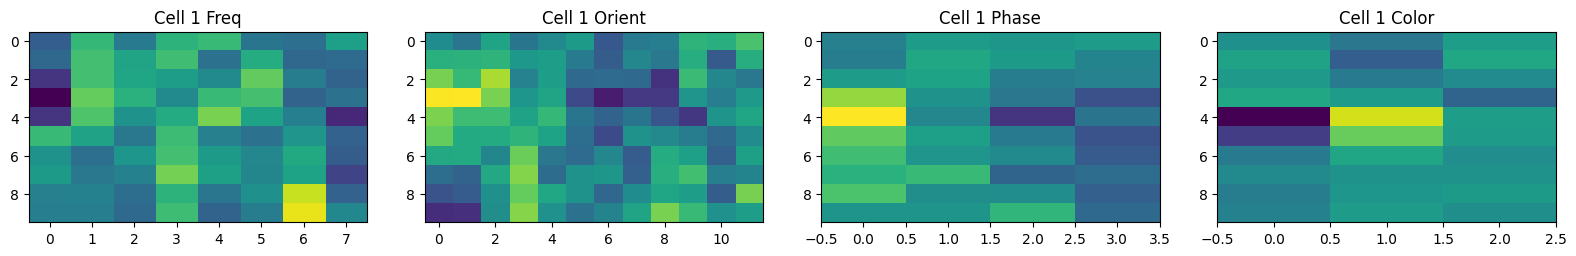

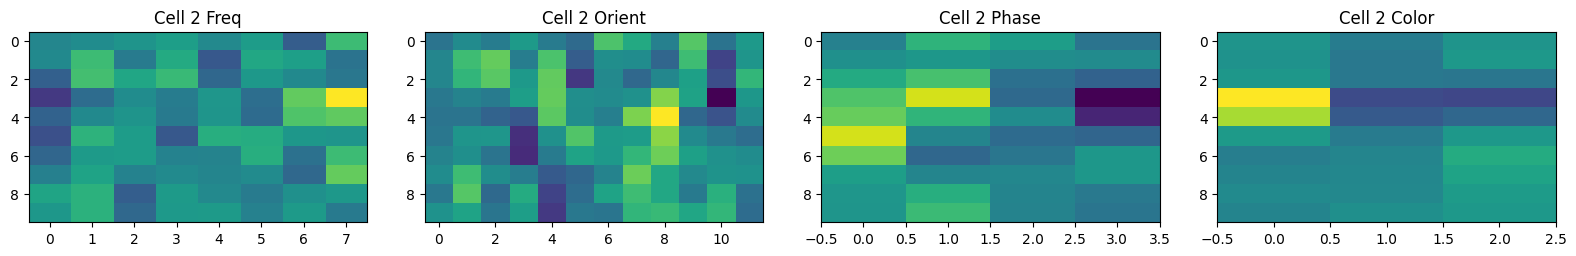

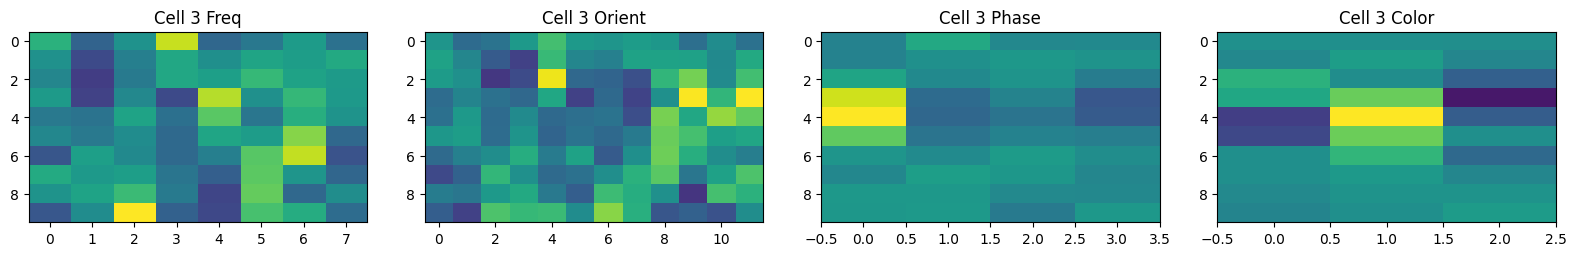

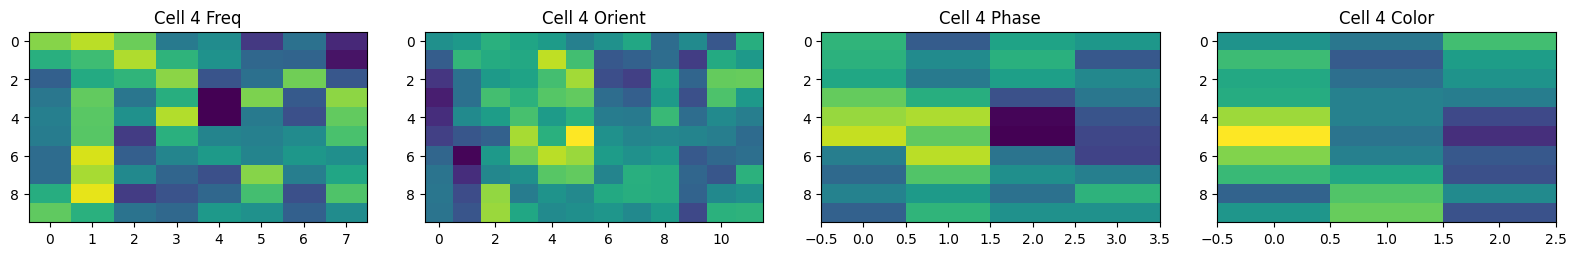

In [6]:
k = glm.get_weights()
k_freq = k[:8]                  # Spacial frequency filter
k_orient = k[8:20]              # Orientation filter
k_phase = k[20:24]              # Phase shift filter
k_color = k[24:]                # Color channel filter

cells = 5
for cc in range(cells):
    ss(1, 4)
    plt.subplot(1, 4, 1)
    plt.title(f'Cell {str(cc)} Freq')
    imagesc(k_freq[:,:,cc])
    plt.subplot(1, 4, 2)
    plt.title(f'Cell {str(cc)} Orient')
    imagesc(k_orient[:,:,cc])
    plt.subplot(1, 4, 3)
    plt.title(f'Cell {str(cc)} Phase')
    imagesc(k_phase[:,:,cc])
    plt.subplot(1, 4, 4)
    plt.title(f'Cell {str(cc)} Color')
    imagesc(k_color[:,:,cc])
plt.show()

In [7]:
# Find metadata values at optimal lag
freq = np.zeros([data.NC, k_freq.shape[0]])
orient = np.zeros([data.NC, k_orient.shape[0]])
phase = np.zeros([data.NC, k_phase.shape[0]])
color = np.zeros([data.NC, k_color.shape[0]])

for cc in range(data.NC):
    lag_freq = np.argmax(np.var(k_freq[:,:,cc], axis=0))
    lag_orient = np.argmax(np.var(k_orient[:,:,cc], axis=0))
    lag_phase = np.argmax(np.var(k_phase[:,:,cc], axis=0))
    lag_color = np.argmax(np.var(k_color[:,:,cc], axis=0))
    
    freq[cc] = k_freq[:,lag_freq,cc]
    orient[cc] = k_orient[:,lag_orient,cc]
    phase[cc] = k_phase[:,lag_phase,cc]
    color[cc] = k_color[:,lag_color,cc]


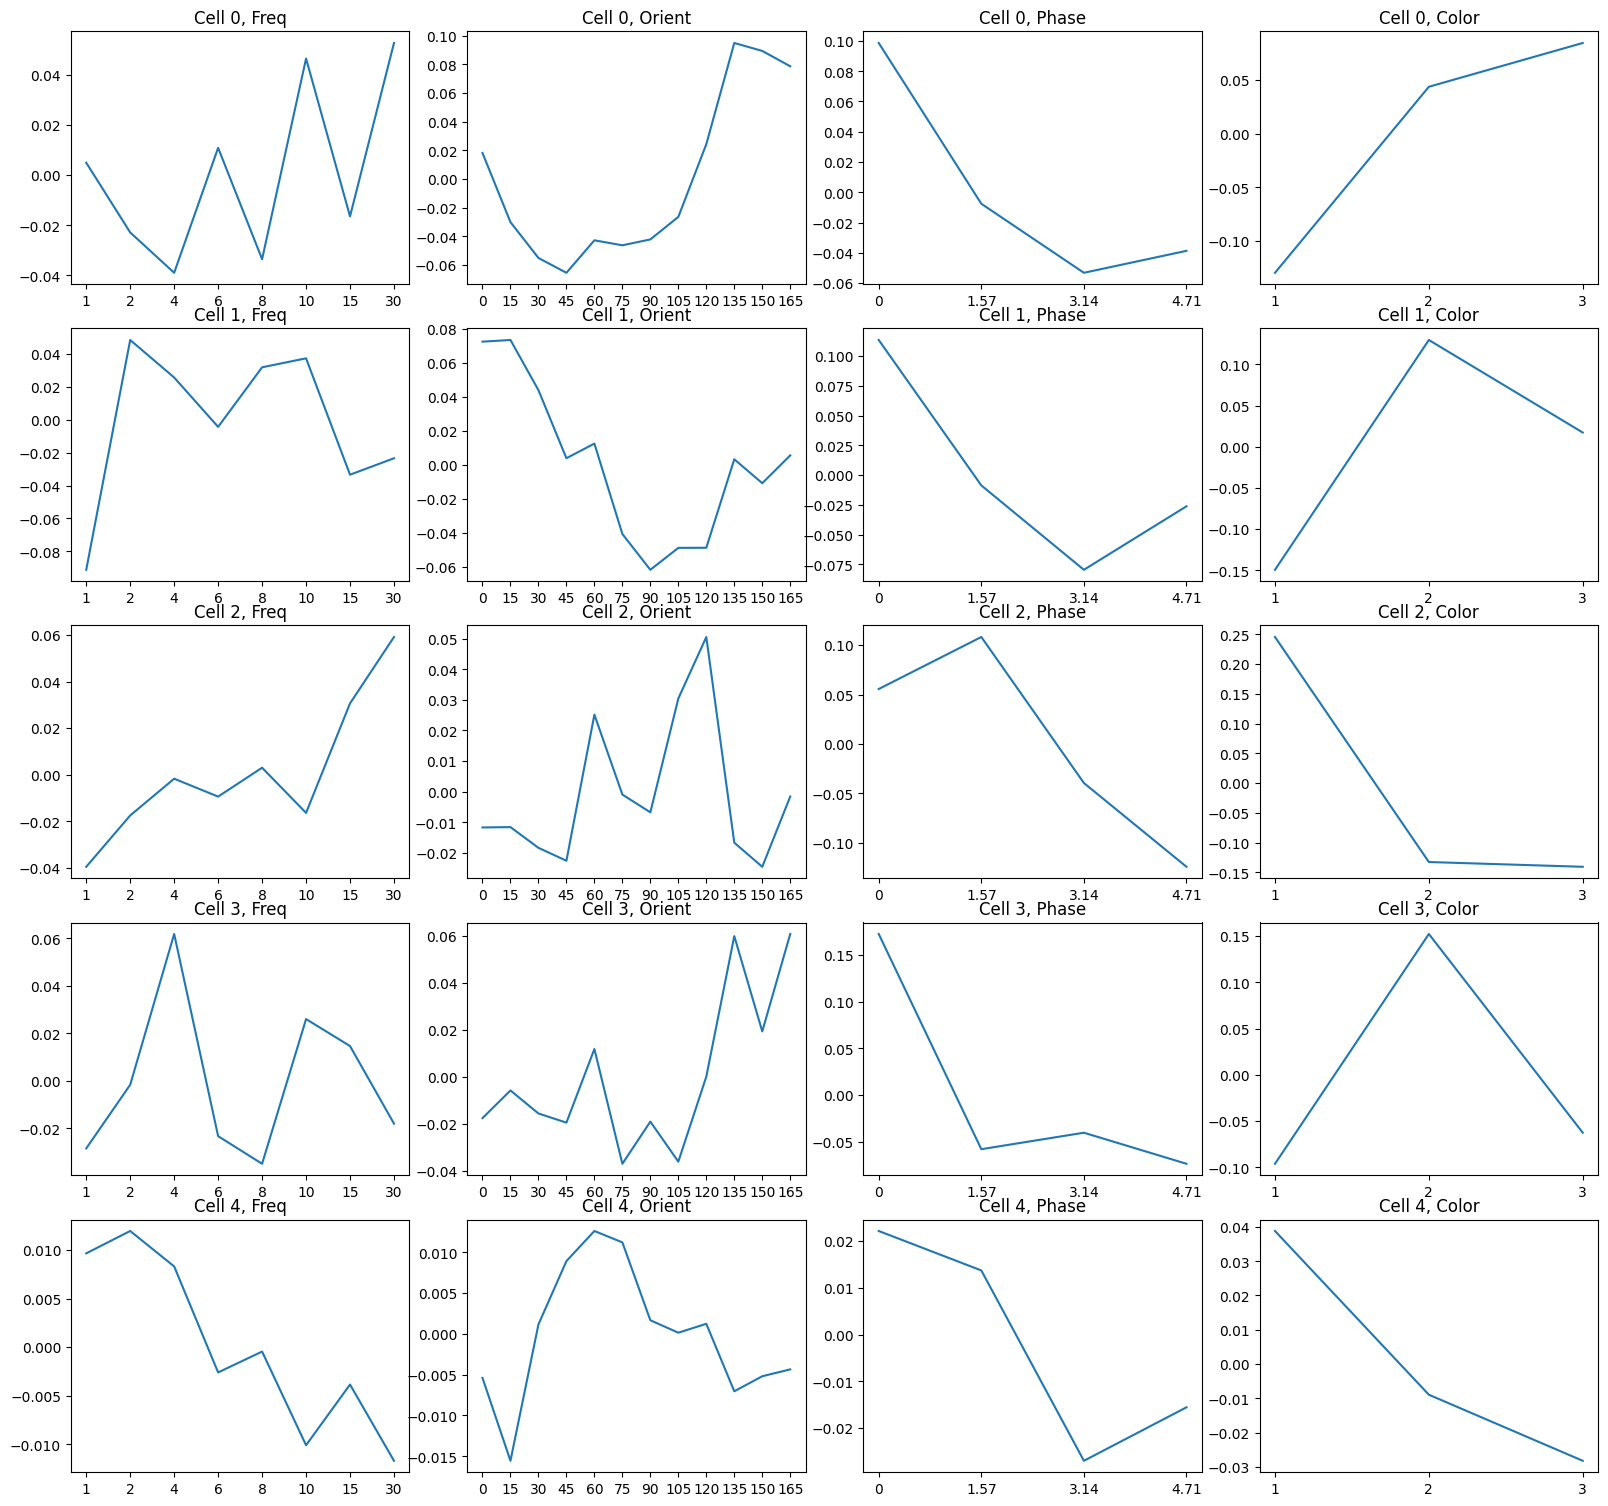

In [8]:
NC=5
ss(NC, 4, row_height=3)
for cc in range(NC):
    
    plt.subplot(NC, 4, 4*cc+1)
    plt.xticks(range(8), [1,2,4,6,8,10,15,30])
    plt.title(f'Cell {cc}, Freq')
    plt.plot(freq[cc])
    
    plt.subplot(NC, 4, 4*cc+2)
    plt.xticks(range(12), [0,15,30,45,60,75,90,105,120,135,150,165])
    plt.title(f'Cell {cc}, Orient')
    plt.plot(orient[cc])
    
    plt.subplot(NC, 4, 4*cc+3)
    plt.xticks(range(4), [0,1.57,3.14,4.71])
    plt.title(f'Cell {cc}, Phase')
    plt.plot(phase[cc])
    
    plt.subplot(NC, 4, 4*cc+4)
    plt.xticks(range(3), [1,2,3])
    plt.title(f'Cell {cc}, Color')
    plt.plot(color[cc])
    
plt.show()

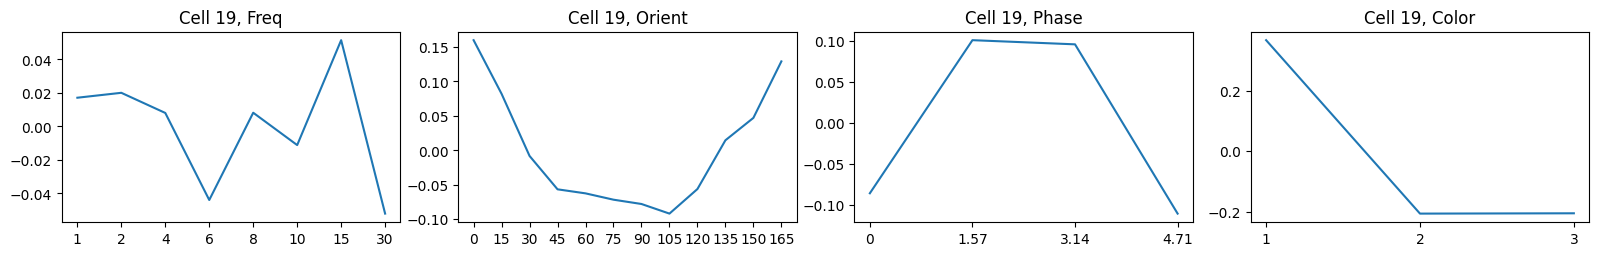

In [65]:
ss(1, 4)

plt.subplot(1, 4, 1)
plt.xticks(range(8), [1,2,4,6,8,10,15,30])
plt.title(f'Cell {19}, Freq')
plt.plot(freq[19])

plt.subplot(1, 4, 2)
plt.xticks(range(12), [0,15,30,45,60,75,90,105,120,135,150,165])
plt.title(f'Cell {19}, Orient')
plt.plot(orient[19])

plt.subplot(1, 4, 3)
plt.xticks(range(4), [0,1.57,3.14,4.71])
plt.title(f'Cell {19}, Phase')
plt.plot(phase[19])

plt.subplot(1, 4, 4)
plt.xticks(range(3), [1,2,3])
plt.title(f'Cell {19}, Color')
plt.plot(color[19])